In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from env.portfolio_env import PortfolioEnv
from models.rl_agent import train_rl_agent, evaluate_agent
from features.features_builder import build_rl_features

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
returns_df, features_df = build_rl_features()

/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/RL_Portfolio_Project/data/data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Model is not converging.  Current: 3544.059354280551 is not greater than 3544.0751173442777. Delta is -0

In [4]:
env = PortfolioEnv(features=features_df, returns=returns_df, verbose=False)


In [5]:
model = train_rl_agent(env, timesteps=100_000, verbose=1)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1118 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 652         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006542257 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.51       |
|    explained_variance   | -1.41       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0138     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0149     |
|    std                  | 0.997       |
|    value_loss           | 0.0126      |
-----------------

In [6]:
history, infos = evaluate_agent(model, env)


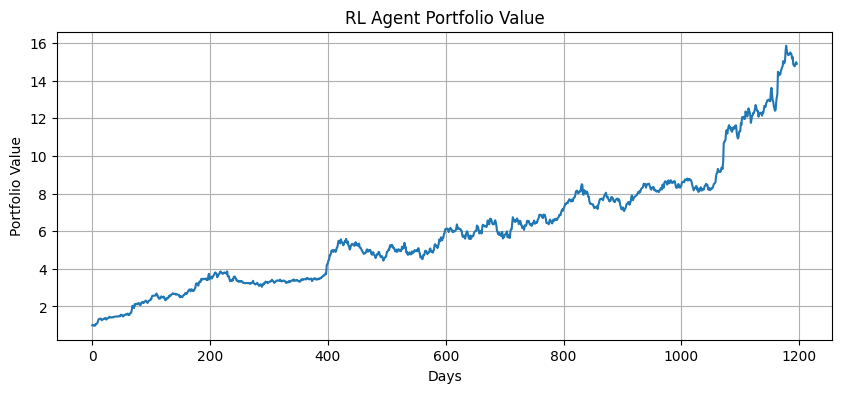

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(history)
plt.title("RL Agent Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [8]:
model.save("ppo_portfolio_agent.zip")


In [9]:
from stable_baselines3 import PPO
model = PPO.load("ppo_portfolio_agent.zip")
